### Rappel Google Colab

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. 
Installer ensuite deeplib avec la commande suivante:

In [ ]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

# Laboratoire 3: Optimisation

## Partie 4: Initialization

Dans cette section, vous testerez différentes techniques d'initialisations et observerez leurs effets sur le gradient et l'entraînement.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torchvision.transforms import ToTensor

from deeplib.datasets import train_valid_loaders
from deeplib.training import train, test

plt.rcParams['figure.dpi'] = 150

from deeplib.datasets import load_mnist, load_cifar10
cifar_train, cifar_test = load_cifar10()
cifar_train.transform = ToTensor()
cifar_test.transform = ToTensor()

train_loader, valid_loader = train_valid_loaders(cifar_train, 10)

Files already downloaded and verified
Files already downloaded and verified


On crée ici un réseau de neurones assez simple composé de 5 couches cachées (6 couches au total) et avec un choix pour la fonction d'activation.

In [2]:
activations = dict(
    tanh=nn.Tanh,
    relu=nn.ReLU
)

def create_fully_connected_network(activation):
    assert activation in activations
    activation = activations[activation]
    num_neurons = 1000
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(32*32*3, num_neurons),
        activation(),
        nn.Linear(num_neurons, num_neurons),
        activation(),
        nn.Linear(num_neurons, num_neurons),
        activation(),
        nn.Linear(num_neurons, num_neurons),
        activation(),
        nn.Linear(num_neurons, num_neurons),
        activation(),
        nn.Linear(num_neurons, 10)
    )

On va jouer avec différentes fonctions d'initialisation. Créons donc une fonction nous permettant d'initialiser tous les poids de notre réseau de neurones.

In [3]:
def initialize_network(network, initialization_function):
    for module in network.modules():
        if isinstance(module, nn.Linear):
            initialization_function(module.weight)
            init.zeros_(module.bias)

On s'intéresse aux gradients qui circule dans le réseau de neurones lors de la rétropropagation. Ceci est à distinguer du gradient calculé pour chacun des poids individuels du réseau de neurones. Le gradient circulant pendant la rétropropagation nous donne une idée de la possibilité de changements des poids de la couche en question. De manière équivalente, le gradient qui circule dans le réseau est le même que celui des biais des couches linéaires. Les fonctions suivantes procèdent donc de la façon suivante:
- On parcourt le jeu de données d'entraînement en batch;
- Pour chacune des batchs, on garde pour chacune des couches le gradient des biais de la couche;
- Une fois que toutes les batchs ont été traitées, on calcule un histogramme des gradients pour chaque couche.

In [4]:
def save_gradient(sequential_network, output_dictionary):
    layer_number = 1
    for layer in sequential_network:
        if isinstance(layer, nn.Linear):
            # On ignore la dernière couche qui est la couche de 
            # classification.
            if layer_number == 6:
                continue

            with torch.no_grad():
                grad = layer.bias.grad.flatten().cpu().numpy()
            grad = grad[grad != 0]
            output_dictionary[layer_number].append(grad)
            layer_number += 1

def plot_gradients_per_layer(gradients_per_layer):
    for layer_number, grads in gradients_per_layer.items():
        grad = np.concatenate(grads)
        hist, bin_edges = np.histogram(grad, bins=100)
        hist = hist / hist.sum() * 100

        plt.plot(bin_edges[:-1], hist, label=f'Layer {layer_number}')

def plot_gradient(network):
    gradients_per_layer = defaultdict(list)
    network.cuda()
    for x, y in train_loader:
        x = x.cuda()
        y = y.cuda()
        
        output = network(x)
        loss = F.cross_entropy(output, y)
        loss.backward()
        
        save_gradient(network, gradients_per_layer)

        network.zero_grad(True)

    plot_gradients_per_layer(gradients_per_layer)
    plt.legend()

La fonction ci-dessous est la fonction qui est utilisée comme référence dans [l'article introduisant l'initialisation Glorot/Xavier](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) et est d'ailleurs celle utilisé par PyTorch par défaut dans les couches linéaires. Nous allons l'utiliser pour la comparer avec l'initilisation de Glorot/Xavier et celle de Kaiming He.

In [5]:
def standard_uniform(weight):
    bound = 1. / np.sqrt(weight.shape[1])
    init.uniform_(weight, -bound, bound)

### 4.1 Réseau avec activation tanh

La fonction tanh était la fonction d'activation la plus utilisée avant l'arrivée de la fonction ReLU. Plusieurs fonctions d'initialisation ont donc été conçues avec cette fonction d'activation en tête. Investiguons donc l'effet des différentes fonctions d'initialisation sur un réseau avec des activations tanh.

In [6]:
tanh_network = create_fully_connected_network('tanh')
tanh_network

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=1000, bias=True)
  (2): Tanh()
  (3): Linear(in_features=1000, out_features=1000, bias=True)
  (4): Tanh()
  (5): Linear(in_features=1000, out_features=1000, bias=True)
  (6): Tanh()
  (7): Linear(in_features=1000, out_features=1000, bias=True)
  (8): Tanh()
  (9): Linear(in_features=1000, out_features=1000, bias=True)
  (10): Tanh()
  (11): Linear(in_features=1000, out_features=10, bias=True)
)

Regardons l'histogramme des gradients lorsqu'on utilise l'initialisation standard (de référence).

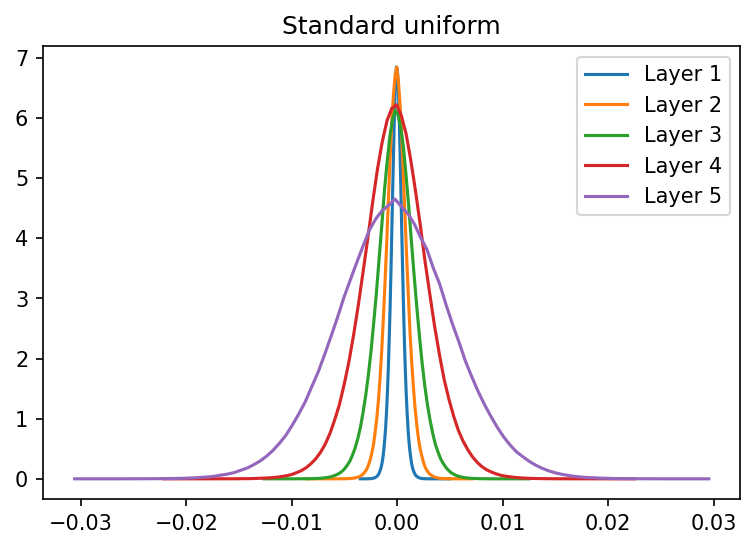

In [7]:
initialize_network(tanh_network, standard_uniform)

plot_gradient(tanh_network)
plt.title('Standard uniform')
plt.show()

Regardons l'histogramme des gradients lorsqu'on utilise l'initialisation de Glorot/Xavier.

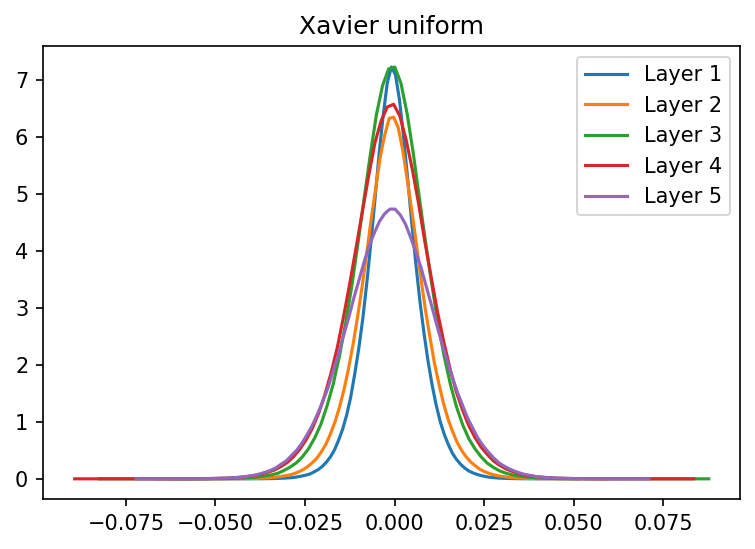

In [8]:
initialize_network(tanh_network, init.xavier_uniform_)

plot_gradient(tanh_network)
plt.title('Xavier uniform')
plt.show()

Regardons l'histogramme des gradients lorsqu'on utilise l'initialisation de Kaiming He.

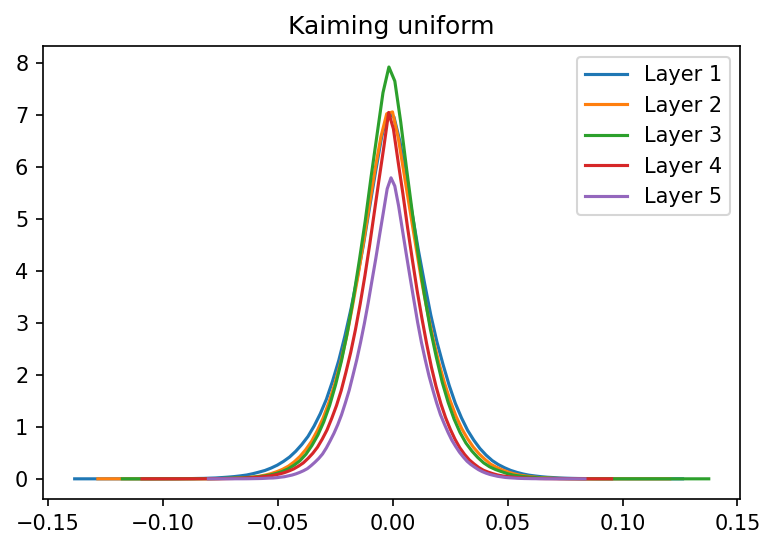

In [9]:
initialize_network(tanh_network, init.kaiming_uniform_)

plot_gradient(tanh_network)
plt.title('Kaiming uniform')
plt.show()

#### Questions
- À partir des graphiques pour chacune des fonctions d'initialisation, que peut-on dire sur la différence d'initialisation entre les différents types d'initialisation? **Pour l'activation standard, on peut voir que la différence entre les variances de chacune des couches est plus grande pour les couches plus près de la sortie du réseau que de celle plus près de l'entrée du réseau. Avec les initialisations Xavier et Glorot, on peut voir que cette différence est amoindrie.**
- Intuitivement, pourquoi serait-il préférable d'avoir une variance similaire pour le gradient circulant dans chacune des couches? **On pourrait argumenter que d'avoir une variance similaire permet à chacune des couches d'apprendre à la même vitesse.**

Maintenant que l'on a observé l'effet de l'initialisation sur le gradient circulant dans le réseau, regardons si l'effet est répercuté sur l'apprentissage.

In [10]:
batch_size = 128
epochs = 5

Entraînons le réseau avec l'initialisation standard.

Epoch: 1/5 Train steps: 313 Val steps: 79 5.78s loss: 2.286147 acc: 13.040000 val_loss: 2.260734 val_acc: 20.460000
Epoch: 2/5 Train steps: 313 Val steps: 79 5.86s loss: 2.172967 acc: 22.770000 val_loss: 2.086595 val_acc: 25.150000
Epoch: 3/5 Train steps: 313 Val steps: 79 5.80s loss: 2.045452 acc: 25.825000 val_loss: 2.013733 val_acc: 28.280000
Epoch: 4/5 Train steps: 313 Val steps: 79 5.81s loss: 1.976285 acc: 28.322500 val_loss: 1.950488 val_acc: 29.840000
Epoch: 5/5 Train steps: 313 Val steps: 79 5.80s loss: 1.922286 acc: 30.687500 val_loss: 1.901782 val_acc: 31.690000


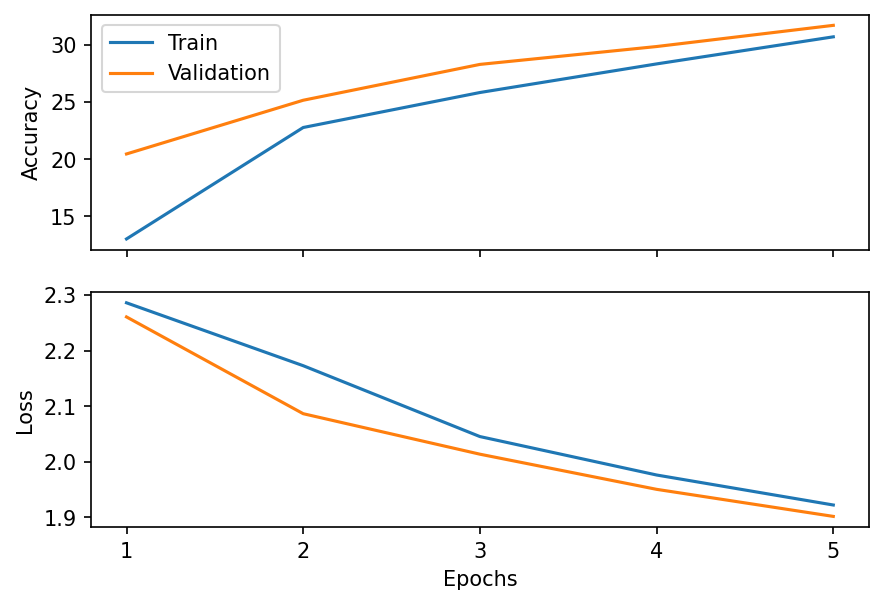

Test steps: 79 1.02s test_loss: 1.899432 test_acc: 31.530000                                                
Exactitude en test: 31.53


In [11]:
initialize_network(tanh_network, standard_uniform)

history = train(tanh_network, 'sgd', cifar_train, epochs, batch_size)
history.display()
print('Exactitude en test: {:.2f}'.format(test(tanh_network, cifar_test, batch_size)))

Regardons maintenant l'histogramme des gradients du réseau entraîné avec l'initialisation standard.

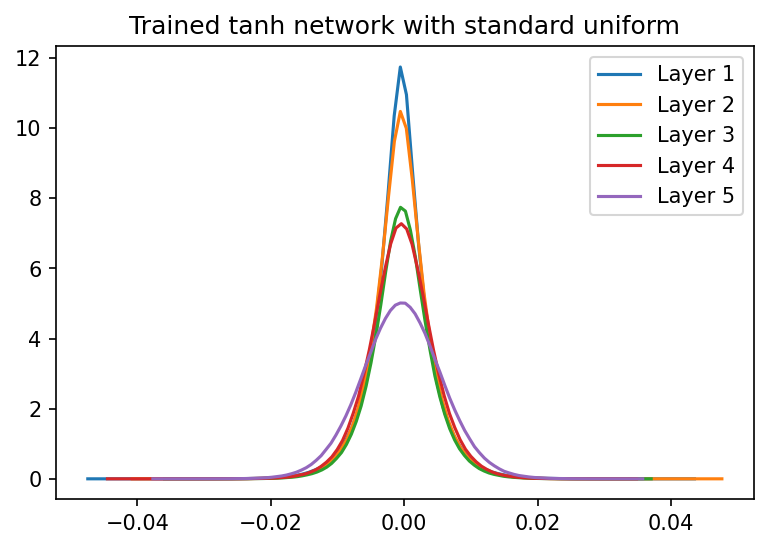

In [12]:
plot_gradient(tanh_network)
plt.title('Trained tanh network with standard uniform')
plt.show()

#### Questions
- Quelle différence remarquez-vous par rapport à l'histogramme du gradient circulant de l'initialisation standard avant l'entraînement (Voir le graphique "Standard uniform" plus haut) ? **On remarque que l'entraînement a eu pour effet de réduire la différence de variances entre les couches.**

Entraînons le réseau avec l'initialisation Xavier.

Epoch: 1/5 Train steps: 313 Val steps: 79 5.85s loss: 1.937662 acc: 30.425000 val_loss: 1.876264 val_acc: 31.690000
Epoch: 2/5 Train steps: 313 Val steps: 79 5.83s loss: 1.801785 acc: 36.252500 val_loss: 1.777003 val_acc: 36.210000
Epoch: 3/5 Train steps: 313 Val steps: 79 5.85s loss: 1.742345 acc: 38.585000 val_loss: 1.752257 val_acc: 37.820000
Epoch: 4/5 Train steps: 313 Val steps: 79 5.88s loss: 1.713357 acc: 39.702500 val_loss: 1.758076 val_acc: 37.810000
Epoch: 5/5 Train steps: 313 Val steps: 79 5.86s loss: 1.682347 acc: 40.575000 val_loss: 1.762140 val_acc: 36.090000


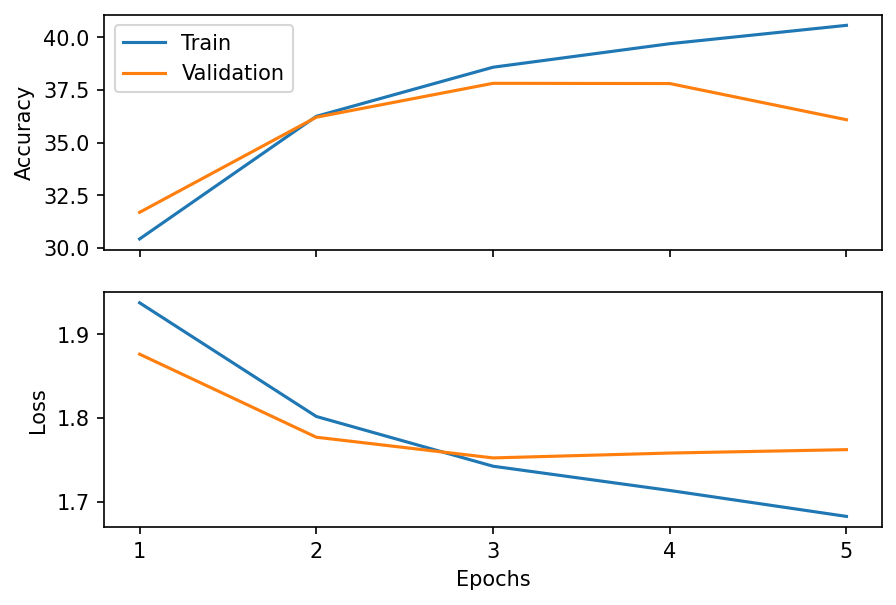

Test steps: 79 1.02s test_loss: 1.752958 test_acc: 35.790000                                                
Exactitude en test: 35.79


In [13]:
initialize_network(tanh_network, init.xavier_uniform_)

history = train(tanh_network, 'sgd', cifar_train, epochs, batch_size)
history.display()
print('Exactitude en test: {:.2f}'.format(test(tanh_network, cifar_test, batch_size)))

Regardons maintenant l'histogramme des gradients du réseau entraîné avec l'initialisation Xavier.

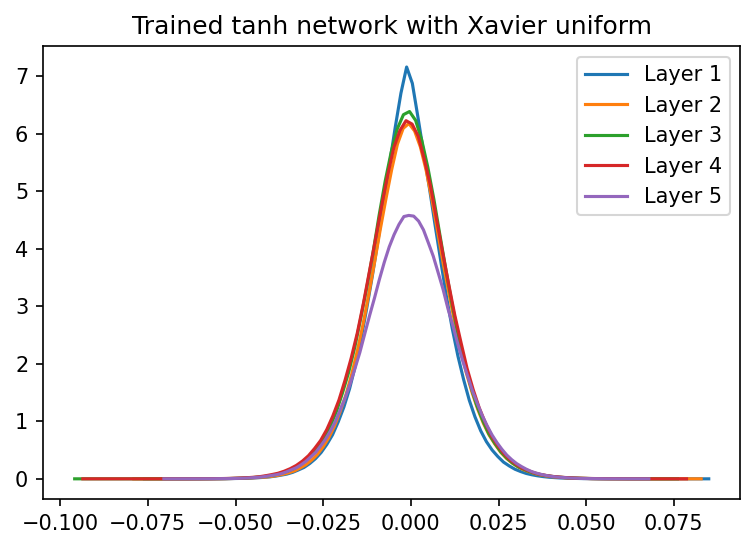

In [14]:
plot_gradient(tanh_network)
plt.title('Trained tanh network with Xavier uniform')
plt.show()

Entraînons le réseau avec l'initialisation Kaiming.

Epoch: 1/5 Train steps: 313 Val steps: 79 5.81s loss: 1.962881 acc: 30.225000 val_loss: 1.807794 val_acc: 35.200000
Epoch: 2/5 Train steps: 313 Val steps: 79 5.74s loss: 1.725739 acc: 38.465000 val_loss: 1.794633 val_acc: 36.970000
Epoch: 3/5 Train steps: 313 Val steps: 79 5.85s loss: 1.640005 acc: 42.070000 val_loss: 1.751203 val_acc: 37.570000
Epoch: 4/5 Train steps: 313 Val steps: 79 5.86s loss: 1.580517 acc: 44.032500 val_loss: 1.665772 val_acc: 40.030000
Epoch: 5/5 Train steps: 313 Val steps: 79 5.78s loss: 1.533703 acc: 45.527500 val_loss: 1.625029 val_acc: 41.840000


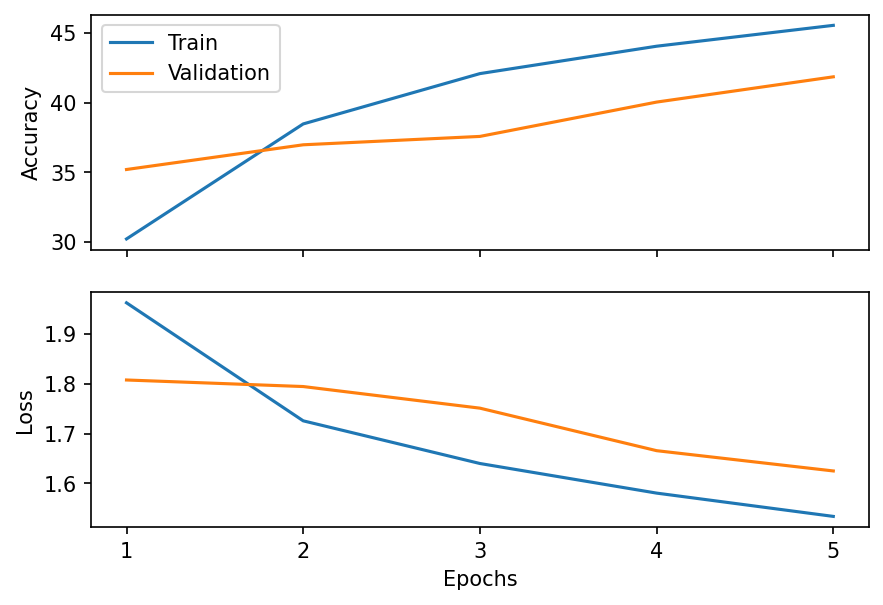

Test steps: 79 1.01s test_loss: 1.620684 test_acc: 42.820000                                                
Exactitude en test: 42.82


In [15]:
initialize_network(tanh_network, init.kaiming_uniform_)

history = train(tanh_network, 'sgd', cifar_train, epochs, batch_size)
history.display()
print('Exactitude en test: {:.2f}'.format(test(tanh_network, cifar_test, batch_size)))

Regardons maintenant l'histogramme des gradients du réseau entraîné avec l'initialisation Kaiming.

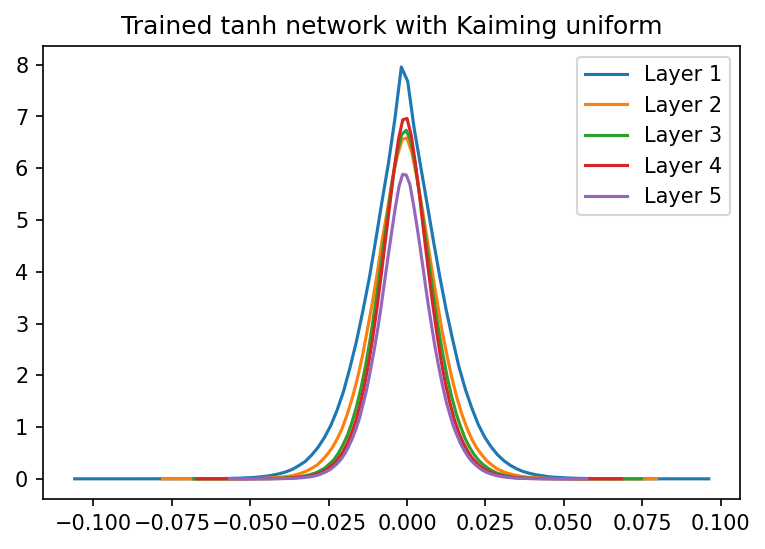

In [16]:
plot_gradient(tanh_network)
plt.title('Trained tanh network with Kaiming uniform')
plt.show()

#### Questions
- Que notez-vous en terme de performances des différentes techniques d'initialisation? **On remarque que les initialisations Xavier et Kaming offrent de meilleurs performances.**
- Comparez les graphiques pour les initialisations Xavier et Kaiming avant et après entraînement. Que remarquez-vous ? **On remarque qu'il y a bien peu de différences entre avant et après l'entraînement, même s'il y en a une petite.**

### 4.2 Réseau avec activation ReLU

Effectuons donc le même processus mais c'est fois-ci avec la fonction ReLU. 

>Notons que la fonction calculant les histogrammes enlève tous les gradient qui sont exactement à zéro. Autrement, chaque histogramme aurait un grand pic à zéro nous empêchant de voir la distribution du reste des gradients.

In [17]:
relu_network = create_fully_connected_network('relu')
relu_network

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=1000, bias=True)
  (2): ReLU()
  (3): Linear(in_features=1000, out_features=1000, bias=True)
  (4): ReLU()
  (5): Linear(in_features=1000, out_features=1000, bias=True)
  (6): ReLU()
  (7): Linear(in_features=1000, out_features=1000, bias=True)
  (8): ReLU()
  (9): Linear(in_features=1000, out_features=1000, bias=True)
  (10): ReLU()
  (11): Linear(in_features=1000, out_features=10, bias=True)
)

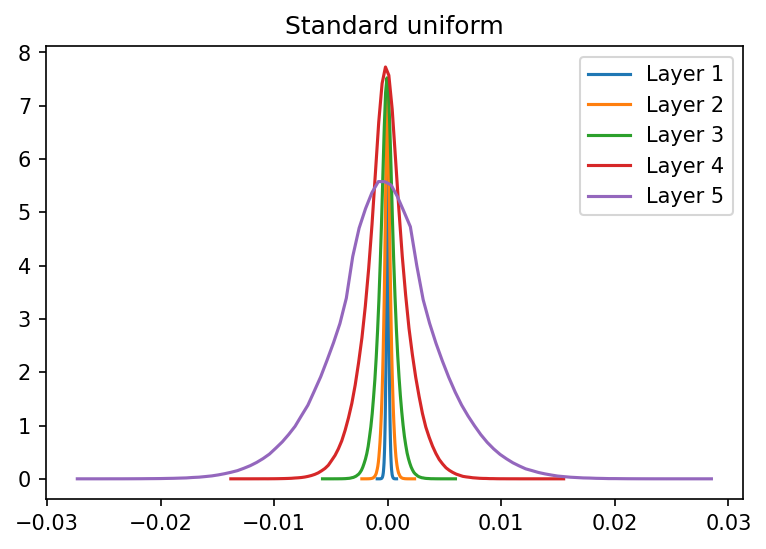

In [18]:
initialize_network(relu_network, standard_uniform)

plot_gradient(relu_network)
plt.title('Standard uniform')
plt.show()

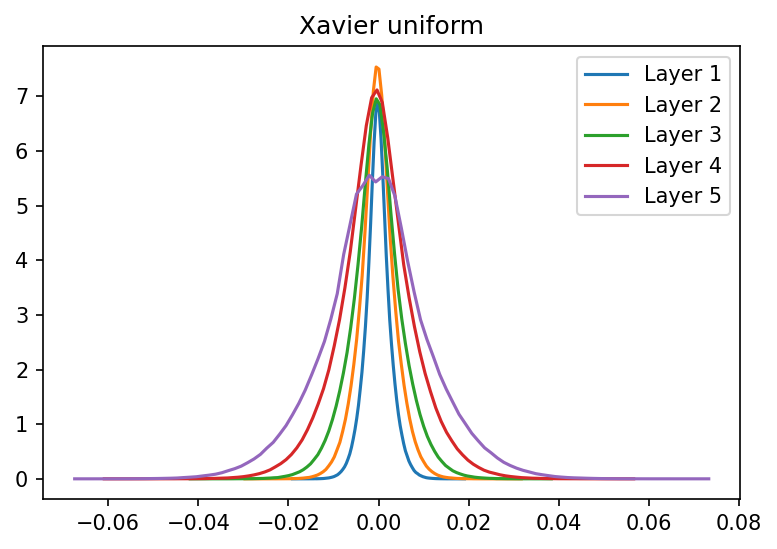

In [19]:
initialize_network(relu_network, init.xavier_uniform_)

plot_gradient(relu_network)
plt.title('Xavier uniform')
plt.show()

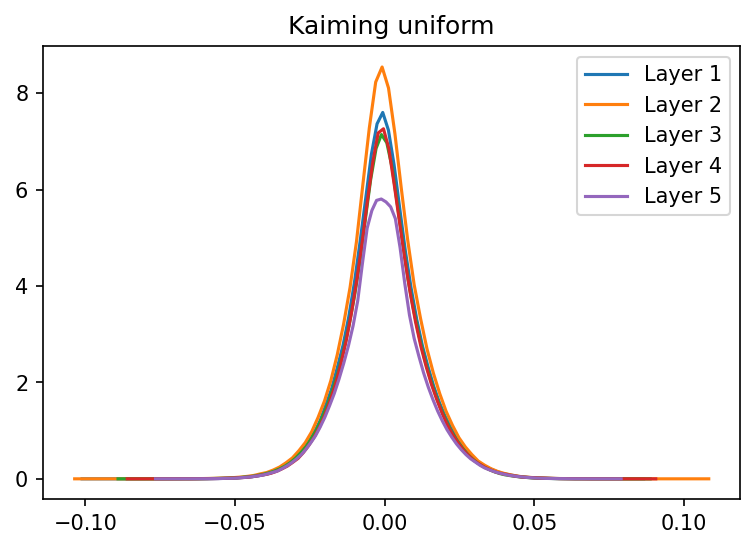

In [20]:
initialize_network(relu_network, init.kaiming_uniform_)

plot_gradient(relu_network)
plt.title('Kaiming uniform')
plt.show()

Effectuons les entraînements avec les différentes fonctions d'initialisation.

Epoch: 1/5 Train steps: 313 Val steps: 79 5.91s loss: 2.301652 acc: 13.537500 val_loss: 2.300772 val_acc: 18.680000
Epoch: 2/5 Train steps: 313 Val steps: 79 5.89s loss: 2.299602 acc: 17.897500 val_loss: 2.298295 val_acc: 18.560000
Epoch: 3/5 Train steps: 313 Val steps: 79 5.86s loss: 2.295909 acc: 17.425000 val_loss: 2.292896 val_acc: 17.660000
Epoch: 4/5 Train steps: 313 Val steps: 79 5.84s loss: 2.286132 acc: 17.847500 val_loss: 2.276096 val_acc: 16.690000
Epoch: 5/5 Train steps: 313 Val steps: 79 5.88s loss: 2.246903 acc: 16.470000 val_loss: 2.199913 val_acc: 17.570000


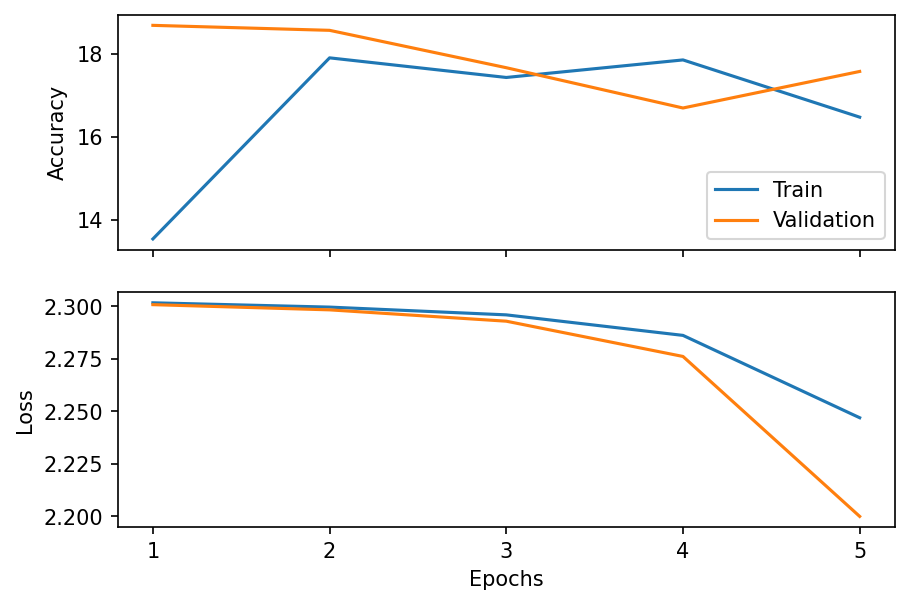

Test steps: 79 1.00s test_loss: 2.199866 test_acc: 17.800000                                                
Exactitude en test: 17.80


In [21]:
initialize_network(relu_network, standard_uniform)

history = train(relu_network, 'sgd', cifar_train, epochs, batch_size)
history.display()
print('Exactitude en test: {:.2f}'.format(test(relu_network, cifar_test, batch_size)))

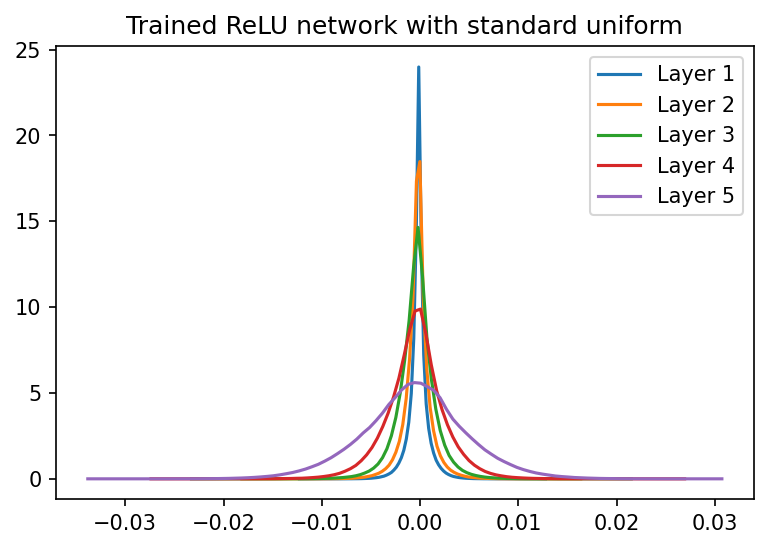

In [22]:
plot_gradient(relu_network)
plt.title('Trained ReLU network with standard uniform')
plt.show()

Epoch: 1/5 Train steps: 313 Val steps: 79 5.82s loss: 2.071674 acc: 25.765000 val_loss: 1.918748 val_acc: 32.300000
Epoch: 2/5 Train steps: 313 Val steps: 79 5.83s loss: 1.865195 acc: 33.747500 val_loss: 1.805170 val_acc: 35.350000
Epoch: 3/5 Train steps: 313 Val steps: 79 5.78s loss: 1.779936 acc: 36.802500 val_loss: 1.741436 val_acc: 37.620000
Epoch: 4/5 Train steps: 313 Val steps: 79 5.79s loss: 1.721419 acc: 39.090000 val_loss: 1.736623 val_acc: 38.570000
Epoch: 5/5 Train steps: 313 Val steps: 79 5.74s loss: 1.673092 acc: 40.840000 val_loss: 1.682147 val_acc: 39.390000


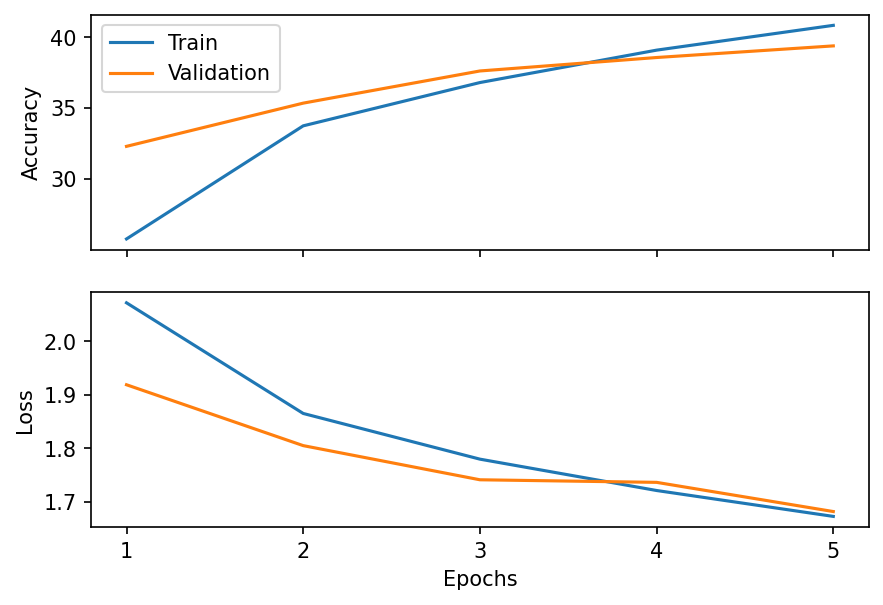

Test steps: 79 1.01s test_loss: 1.671777 test_acc: 41.050000                                                
Exactitude en test: 41.05


In [23]:
initialize_network(relu_network, init.xavier_uniform_)

history = train(relu_network, 'sgd', cifar_train, epochs, batch_size)
history.display()
print('Exactitude en test: {:.2f}'.format(test(relu_network, cifar_test, batch_size)))

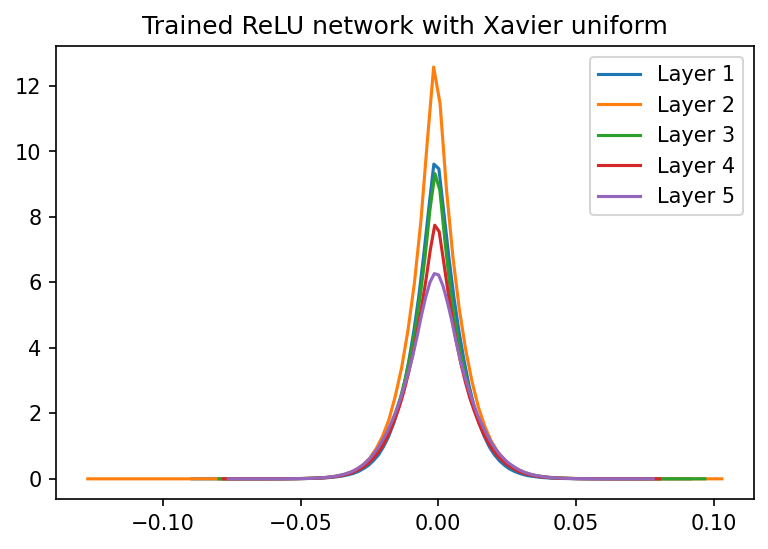

In [24]:
plot_gradient(relu_network)
plt.title('Trained ReLU network with Xavier uniform')
plt.show()

Epoch: 1/5 Train steps: 313 Val steps: 79 5.78s loss: 1.923585 acc: 30.952500 val_loss: 1.834997 val_acc: 34.780000
Epoch: 2/5 Train steps: 313 Val steps: 79 5.83s loss: 1.739655 acc: 38.297500 val_loss: 1.817062 val_acc: 33.810000
Epoch: 3/5 Train steps: 313 Val steps: 79 5.78s loss: 1.658211 acc: 41.375000 val_loss: 1.852656 val_acc: 35.030000
Epoch: 4/5 Train steps: 313 Val steps: 79 5.81s loss: 1.595841 acc: 43.280000 val_loss: 1.633768 val_acc: 40.270000
Epoch: 5/5 Train steps: 313 Val steps: 79 5.80s loss: 1.552668 acc: 45.292500 val_loss: 1.626518 val_acc: 41.660000


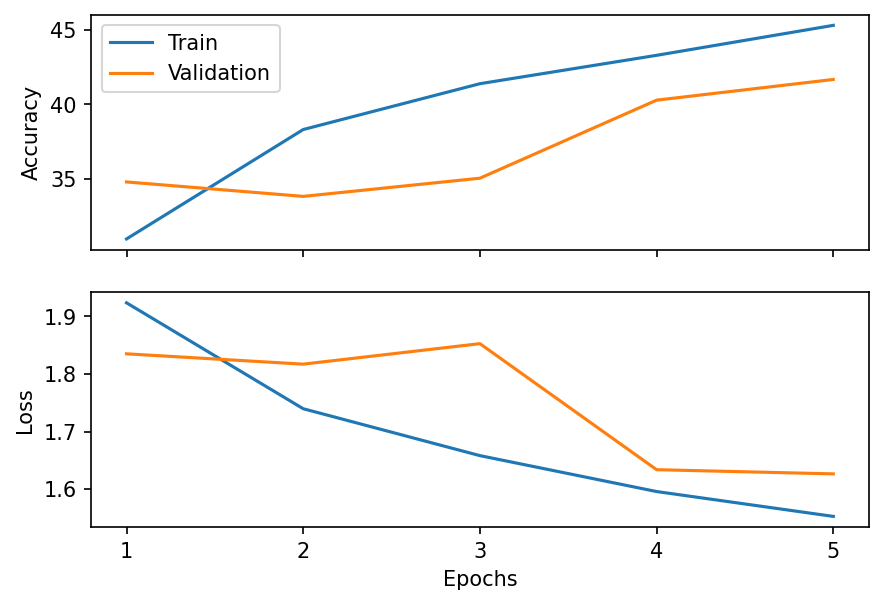

Test steps: 79 1.01s test_loss: 1.590322 test_acc: 43.510000                                                
Exactitude en test: 43.51


In [25]:
initialize_network(relu_network, init.kaiming_uniform_)

history = train(relu_network, 'sgd', cifar_train, epochs, batch_size)
history.display()
print('Exactitude en test: {:.2f}'.format(test(relu_network, cifar_test, batch_size)))

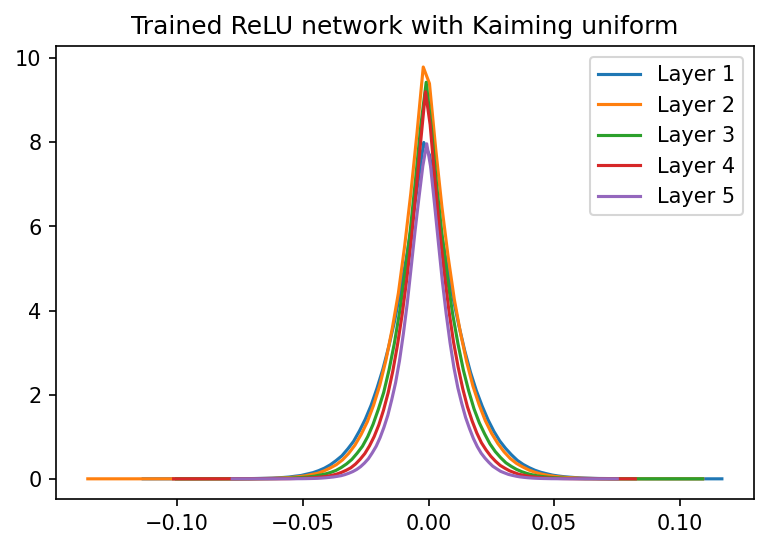

In [26]:
plot_gradient(relu_network)
plt.title('Trained ReLU network with Kaiming uniform')
plt.show()

#### Questions
- Quelles similarités remarquez-vous en terme de performance et de gradient entre le réseau avec activation tanh et le réseau avec activation ReLU?
  - **Les graphiques de gradient pour la tanh et la ReLU avant l'entraînement sont très similaires pour chaque fonction d'initialisation respective.**
  - **Peu importe la fonction d'activation, utiliser les activations Xavier et Kaiming a aidé l'optimisation du réseau.**
- Quelles différences remarquez-vous en terme de performance et de gradient entre le réseau avec activation tanh et le réseau avec activation ReLU?
  - **L'activation standard a été moins performante dans le cas de la ReLU que de la tanh dans ce cas-ci.**
  - **Il y a eu très peu de changement dans les graphiques de la ReLU après l'entraînement comparativement aux graphiques de la tanh après l'entraînement.**